##  Project Objective

To provide companies with a **data-driven**, **objective**, and **flexible scoring framework** for tracking and improving store and employee performance.

**Important Note** : Due to company data confidentiality and security policies, real data is not provided or displayed. All the data used in this project description is a dummy dataset designed to mimic the statistical behavior of the original data.

---

## Methods Used
-  **Chi-Square Tests**: Testing the statistical significance of distributional behavior of the various performance metrics.
-  **Clustering**: Segmenting stores and employees into performance groups based on physical conditions and behavioral patterns.
-  **Dynamic Weighted Scoring System**: Generating parametrically weighted performance scores adaptable to business objectives.

---

##  1. Methodology

The scoring process follows a structured, multi-step approach combining statistical validation, distribution-based scoring, and weighted aggregation.

-  **1.1 Distribution Identification via Chi-Square Test**
    - An examination of the monthly distribution of store and employee KPIs revealed that some KPIs converged to a beta distribution, while others converged to a normal distribution. This convergence was determined using the eyeball test. However, in subsequent steps, the statistical significance of these distributional behavior was determined using the Chi-Square test.

    - Metrics are classified into:
        - **Beta Distribution (3 metrics)**: Metrics with skewed or bounded distributions (e.g., complete order rate).
        - **Normal Distribution (2 metrics)**: Metrics displaying symmetric bell-shaped distributions (e.g. customer complaint rate)
-  **1.2 Clustering the Store Formats**
    - Migros store formats **—such as M, MM, 3M, and 5M—** differ in terms of characteristics. Due to variations in factors such as average basket size, customer behavior patterns, and store area across these formats, evaluating them within the same cluster may lead to biased or misleading performance indicators. Therefore, each store type is ranked and scored within its own category to ensure a more accurate and context-sensitive performance assessment.
-  **1.3 Scoring via Beta CDF and Sigma Buckets**
    - For **Beta-distributed metrics**:
        - Scoring follows Beta Distribution CDF with scores from **0 to 5**.
    - For **Normally-distributed metrics**:
        - Scoring follows **standard deviation intervals** (μ ± σ ranges), assigning points based on distance from the mean.

-  **1.4 Weighted Aggregation of Scores**
    - Each metric is assigned a **business-priority weight**. The business-priority weight is determined based on the evaluation of blind-ranking results conducted by company experts.
    - The final **weighted average performance score** is computed by multiplying each metric score with its respective weight.

This methodology ensures **fair**, **distribution-sensitive**, and **dynamic performance scoring**, offering reliable insights for store and employee performance tracking.


### 1.1 Distribution Identification via Chi-Square Test
#### 1.1.1 Chi-Square Test for Beta Distribution

##### Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare


##### Generating a Dummy Data Set for Test
To simulate a distribution similar to the real dataset, 600 observations are generated using a Beta distribution with left-skewed characteristics. In Beta distribution, a left-skewed shape is achieved when the α (a) parameter is greater than the β (b) parameter (i.e., a > b). To create such a dataset, the values of a and b are randomly generated using the **np.random.uniform()** function, with b being greater than a.

In [2]:
np.random.seed(33) 
a_rnd = np.round(np.random.uniform(4.5, 5.0), 2)
b_rnd = np.round(np.random.uniform(1.5, 2.0), 2)
dummy_data_beta = np.random.beta(a=a_rnd, b=b_rnd, size=600)

##### Visual Inspection via Histogram

A histogram is plotted to confirm the left-skewed shape visually (eyeball test). The distribution shows a higher concentration towards the right (closer to 1), with a tail on the left — matching left-skewed behavior.

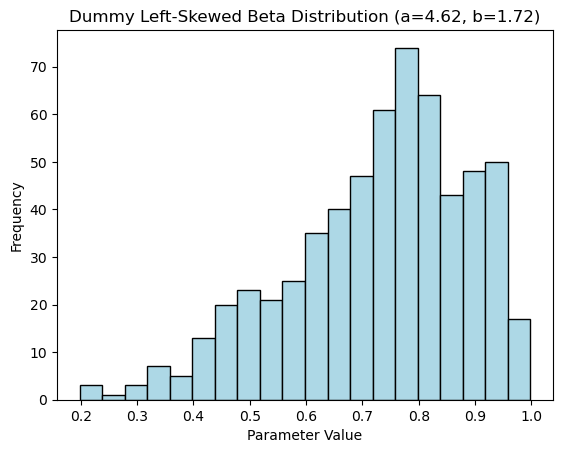

In [3]:
plt.hist(dummy_data_beta, bins=20, color='lightblue', edgecolor='black')
plt.title(f"Dummy Left-Skewed Beta Distribution (a={a_rnd}, b={b_rnd})")
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.show()

##### Estimating the Beta Parameters from Data
To mimic a real-world scenario where the parameters are unknown, we apply maximum likelihood estimation using **scipy.stats.beta.fit()** to estimate **a** and **b** from the dummy data.

In [4]:
from scipy.stats import beta

a_fit, b_fit, loc, scale = beta.fit(dummy_data_beta, floc=0, fscale=1)

print(f" a_fit = {a_fit:.2f}, b_fit= {b_fit:.2f}")


 a_fit = 4.86, b_fit= 1.81


##### Preparing for the Chi-Square Goodness-of-Fit Test

To perform the Chi-Square test:

- The data is binned into equal-width intervals.

- Observed frequencies are calculated from the data histogram.

- Expected frequencies are calculated using the fitted beta distribution's cumulative density function (CDF) to determine the probability mass in each bin.

In [5]:
from scipy.stats import beta, chisquare
import numpy as np
import matplotlib.pyplot as plt

# Creating 10 bins is an statistically accepted approach
num_bins = 10
observed_freq, bin_edges = np.histogram(dummy_data_beta, bins=num_bins)

# Expected frequencies are calculated from fitted beta distribution
expected_freq = []
for i in range(len(bin_edges) - 1):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i + 1]
    # Calculating the theoretical probabilities for every interval (which is the differences of Cumulative Distribution Function)
    probability = beta.cdf(upper_bound, a_fit, b_fit) - beta.cdf(lower_bound, a_fit, b_fit)
    expected_freq.append(probability * len(dummy_data_beta))

expected_freq = np.array(expected_freq)

expected_freq *= observed_freq.sum() / expected_freq.sum()

# Zero value check
print("Expected Frequencies: ", np.round(expected_freq, 2))
print("Zero value check: ", np.any(expected_freq == 0))



Expected Frequencies:  [  3.39   9.3   19.8   35.58  56.31  80.13 103.   117.76 112.28  62.47]
Zero value check:  False


##### Applying the Chi-Square Test

Using scipy.stats.chisquare(), we compare the observed and expected frequencies. The null hypothesis is that the data follows the fitted beta distribution.


Chi-Square Statistic: 6.525
P-Value: 0.6865
Fail to reject H0, The data does not significantly differs from the Beta distribution.


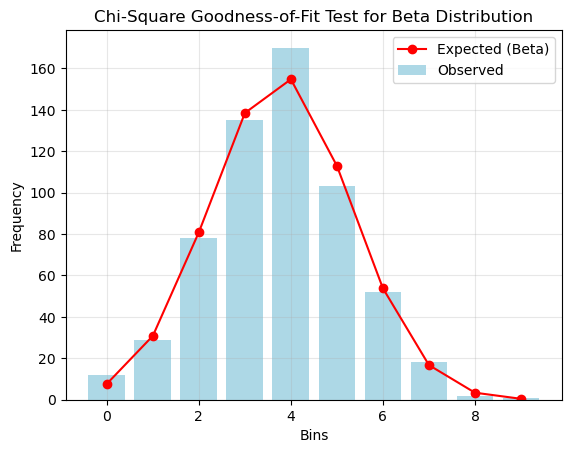

In [22]:
# Applying the Chi-Square Test
chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"\nChi-Square Statistic: {chi2_stat:.3f}")
print(f"P-Value: {p_value:.4f}")

# Hypothesis testing, a significance level of 0.05 was chosen to ensure statistically insightful results.
if p_value < 0.05:
    print("H0 rejected, The data significantly differs from the Beta distribution.")
else:
    print("Fail to reject H0, The data does not significantly differs from the Beta distribution.")

# Plotting the observed frequency vs expected frequency
plt.bar(range(num_bins), observed_freq, label='Observed', color ="lightblue")
plt.plot(range(num_bins), expected_freq, color='red', marker='o', label='Expected (Beta)')
plt.title("Chi-Square Goodness-of-Fit Test for Beta Distribution")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### 1.1.2 Chi-Square Test for Normal Distribution

The same procedural steps are followed when performing the Chi-Square test for the Beta distribution. Therefore, the explanations are not reiterated in detail, and only the corresponding code segment is provided.

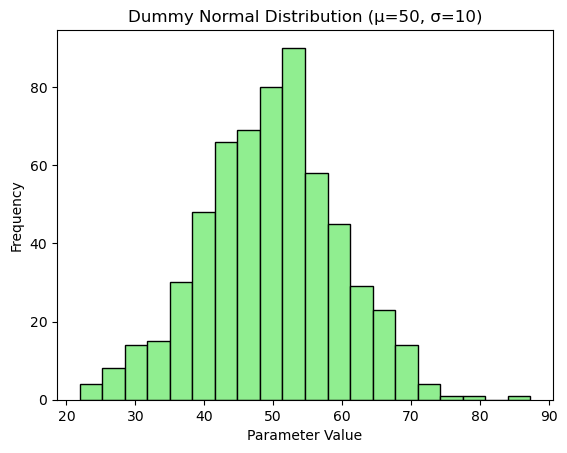

Fitted parameters: μ = 49.80, σ = 9.84
Expected Frequencies: [  7.68  30.85  80.91 138.48 154.76 112.94  53.81  16.73   3.39   0.45]
Zero value check: False

Chi-Square Statistic: 6.525
P-Value: 0.6865
Fail to reject H0, The data does not significantly differs from the Normal distribution.


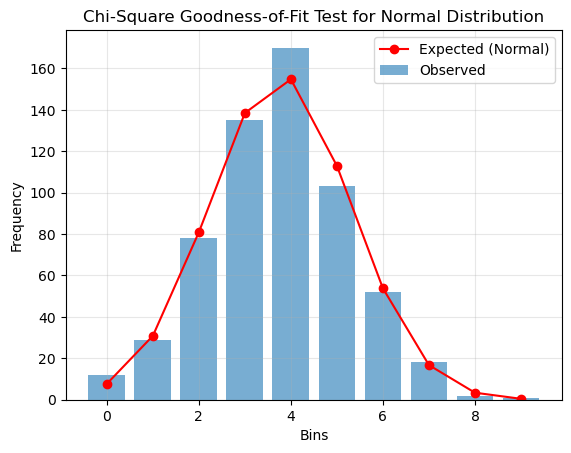

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chisquare

# Creating dummy data set
np.random.seed(33)
mu_rnd = 50
sigma_rnd = 10
dummy_data_normal = np.random.normal(loc=mu_rnd, scale=sigma_rnd, size=600)

# Histogram
plt.hist(dummy_data_normal, bins=20, color='lightgreen', edgecolor='black')
plt.title(f"Dummy Normal Distribution (μ={mu_rnd}, σ={sigma_rnd})")
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.show()

# Fitting the normal distribution
mu_fit, sigma_fit = norm.fit(dummy_data_normal)
print(f"Fitted parameters: μ = {mu_fit:.2f}, σ = {sigma_fit:.2f}")

# Calculating observed frequencies, 10 is selected for number of bins again
num_bins = 10
observed_freq, bin_edges = np.histogram(dummy_data_normal, bins=num_bins)

# Calculating expected frequencies
expected_freq = []
for i in range(len(bin_edges) - 1):
    lower_bound_normal = bin_edges[i]
    upper_bound_normal = bin_edges[i + 1]
    prob = norm.cdf(upper_bound_normal, loc=mu_fit, scale=sigma_fit) - norm.cdf(lower_bound_normal, loc=mu_fit, scale=sigma_fit)
    expected_freq.append(prob * len(dummy_data_normal))

expected_freq = np.array(expected_freq)

expected_freq *= observed_freq.sum() / expected_freq.sum()

# Checking if there are any zero values
print("Expected Frequencies:", np.round(expected_freq, 2))
print("Zero Value Check:", np.any(expected_freq == 0))

# Applying Chi-Square test
chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"\nChi-Square Statistic: {chi2_stat:.3f}")
print(f"P-Value: {p_value:.4f}")

# Hypothesis testing
if p_value < 0.05:
    print("H0 rejected, The data significantly differs from the Normal distribution.")
else:
    print("Fail to reject H0, The data does not significantly differs from the Normal distribution.")

# Plotting
plt.bar(range(num_bins), observed_freq, alpha=0.6, label='Observed')
plt.plot(range(num_bins), expected_freq, color='red', marker='o', label='Expected (Normal)')
plt.title("Chi-Square Goodness-of-Fit Test for Normal Distribution")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### 1.2 Clustering Approach in Performance Evaluation

Migros One is a subsidiary of Migros responsible for managing the company’s e-commerce operations. The operational processes of online orders placed via the Sanalmarket and Hemen applications, which are delivered to customers' homes, are planned and executed by Migros One. Although Migros One oversees the e-commerce operations, the products included in these orders are picked from physical stores. Therefore, the role of physical stores is substantial in both operational planning and ensuring customer satisfaction.

Migros operates through multiple store formats. When calculating performance for different Migros One brands—such as Migros Sanalmarket and Migros Hemen—it is essential to take operational needs and conditions into account. Factors such as product assortment, store size, and geographical location significantly affect variables like order picking time and lead time across different store types (e.g., M, MM, 3M).

For instance, a value of 90% for parameter P might be considered excellent in Store X, whereas a value of 95% for the same parameter might only be considered average in Store Y. 

Similarly, evaluating the picking times of Store Z (200 m²) and Store T (1000 m²) using a single benchmark would lead to inaccurate interpretations.

Therefore, store types are clustered based on their operational characteristics, and performance evaluation is conducted separately within each cluster.

#### 1.3 Scoring via Beta CDF and Sigma Buckets

##### 1.3.1 Scoring Beta-distributed Metrics

Fitted parameters: a = 4.84, b = 1.80
   metric_value_beta  beta_cdf_score
0           0.941836        4.697378
1           0.692763        1.848426
2           0.426502        0.247349
3           0.834128        3.487528
4           0.585123        0.952070


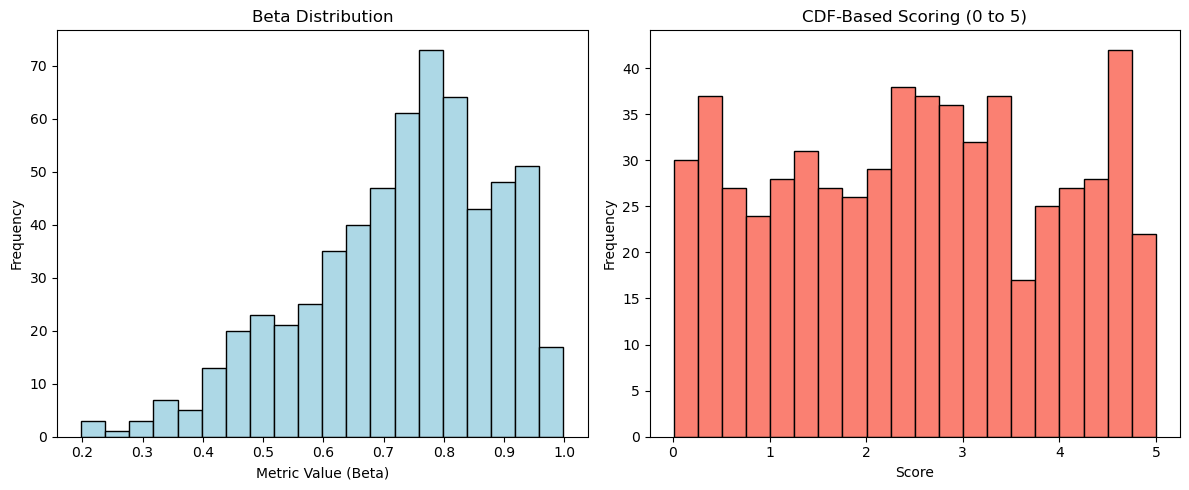

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

# Dummy Beta dataset created in Chi-Square test steps
np.random.seed(33)
a_rnd = 4.62
b_rnd = 1.72
data = np.random.beta(a=a_rnd, b=b_rnd, size=600)

df = pd.DataFrame({'metric_value_beta': data})

a_fit, b_fit, _, _ = beta.fit(df['metric_value_beta'], floc=0, fscale=1)
print(f"Fitted parameters: a = {a_fit:.2f}, b = {b_fit:.2f}")

# Beta-distribution CDF based scoring
df['beta_cdf_score'] = beta.cdf(df['metric_value_beta'], a_fit, b_fit) * 5

print(df.head())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['metric_value_beta'], bins=20, color='lightblue', edgecolor='black')
plt.title("Beta Distribution")
plt.xlabel("Metric Value (Beta)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['beta_cdf_score'], bins=20, color='salmon', edgecolor='black')
plt.title("CDF-Based Scoring (0 to 5)")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


##### 1.3.2 Scoring Normal-distributed Metrics

Fitted parameters: μ = 49.80, σ = 9.84
   metric_value_normal   z_score  z_scaled_score
0            46.811465 -0.303217        2.247319
1            33.970194 -1.607745        1.160213
2            34.647821 -1.538905        1.217579
3            44.295991 -0.558761        2.034366
4            47.832717 -0.199470        2.333775


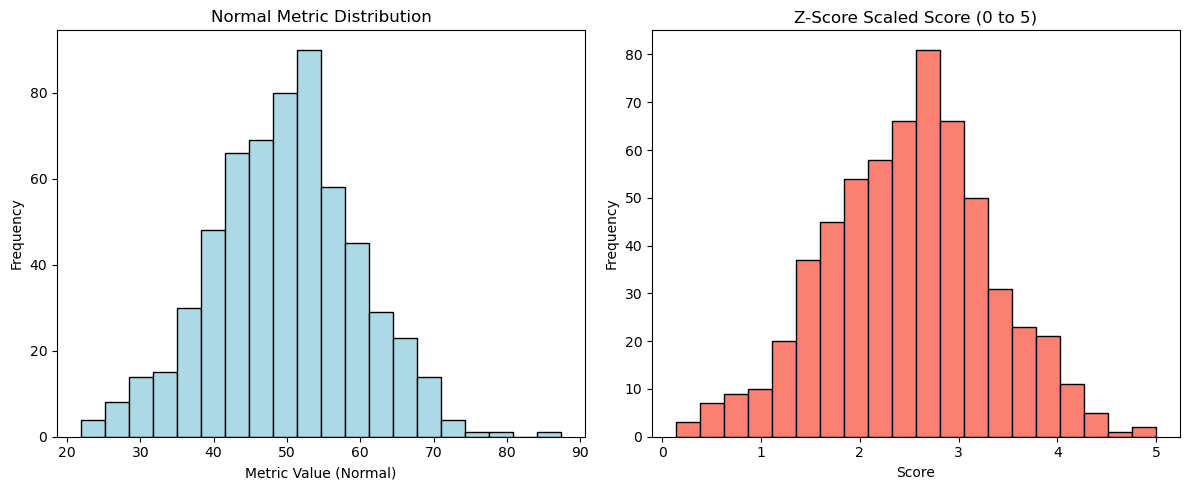

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Dummy Normal dataset created in Chi-Square test steps
np.random.seed(33)
mu_rnd = 50
sigma_rnd = 10
data = np.random.normal(loc=mu_rnd, scale=sigma_rnd, size=600)

df = pd.DataFrame({'metric_value_normal': data})

mu_fit, sigma_fit = norm.fit(df['metric_value_normal'])
print(f"Fitted parameters: μ = {mu_fit:.2f}, σ = {sigma_fit:.2f}")

# Calculating z-scores
df['z_score'] = (df['metric_value_normal'] - mu_fit) / sigma_fit

# Transforming z-scores to a scaled performance score ranging from 0 to 5
df['z_scaled_score'] = np.clip((df['z_score'] + 3) / 6 * 5, 0, 5)

print(df[['metric_value_normal', 'z_score', 'z_scaled_score']].head())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['metric_value_normal'], bins=20, color='lightblue', edgecolor='black')
plt.title("Normal Metric Distribution")
plt.xlabel("Metric Value (Normal)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['z_scaled_score'], bins=20, color='salmon', edgecolor='black')
plt.title("Z-Score Scaled Score (0 to 5)")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



## 1.4 Weighted Aggregation of Scores
After identifying the appropriate statistical distribution for each of the five performance metrics—whether Beta or Normal—individual scores are computed accordingly. 

To ensure that the final composite score accurately reflects business priorities, a weighting process is applied. Initially, each metric is assigned a tentative weight. Then, a blind-ranking evaluation is conducted in which domain experts are asked to assess and rank the performance of a selected set of four stores and employees without seeing the model’s scores.

These expert-generated rankings serve as the ground truth for calibration. Through an iterative trial-and-error process, the metric weights are adjusted such that the model’s aggregated scores yield a ranking that closely mirrors the experts’ assessments. Once a strong alignment between the model output and expert judgment is observed, the weights are deemed valid and finalized. 

The final weighted performance score is then computed by taking the weighted average of the individual metric scores. This approach allows the scoring model to remain both statistically grounded and aligned with operational insights.

## 2. Example

As mentioned earlier, every metric is evaluated independently. In this step, the scores calculated according to the distribution of the metric are taken and final score will be calculated using these independent scores.

##### Score of Metric 1 (Beta Distributed, Seed 33, 71st data point)

In [32]:
import numpy as np
from scipy.stats import beta

np.random.seed(33)
a_rnd = 4.62
b_rnd = 1.72
data = np.random.beta(a=a_rnd, b=b_rnd, size=600)

a_fit, b_fit, _, _ = beta.fit(data, floc=0, fscale=1)

x = data[70]

cdf_score = beta.cdf(x, a_fit, b_fit) * 5

print(f"71st metric value: {x:.4f}")
print(f"CDF-based score (0–5): {cdf_score:.2f}")


71st metric value: 0.7341
CDF-based score (0–5): 2.29


##### Score of Metric 2 (Beta Distributed, Seed 66, 34th data point)

In [33]:
import numpy as np
from scipy.stats import beta

np.random.seed(66)
a_rnd = 4.62
b_rnd = 1.72
data = np.random.beta(a=a_rnd, b=b_rnd, size=600)

a_fit, b_fit, _, _ = beta.fit(data, floc=0, fscale=1)

x = data[34]

cdf_score = beta.cdf(x, a_fit, b_fit) * 5

print(f"34th metric value: {x:.4f}")
print(f"CDF-based score (0–5): {cdf_score:.2f}")


34th metric value: 0.7835
CDF-based score (0–5): 2.90


##### Score of Metric 3 (Beta Distributed, Seed 99, 306th data point)

In [34]:
import numpy as np
from scipy.stats import beta

np.random.seed(99)
a_rnd = 4.62
b_rnd = 1.72
data = np.random.beta(a=a_rnd, b=b_rnd, size=600)

a_fit, b_fit, _, _ = beta.fit(data, floc=0, fscale=1)

x = data[305]

cdf_score = beta.cdf(x, a_fit, b_fit) * 5

print(f"306th metric value: {x:.4f}")
print(f"CDF-based score (0–5): {cdf_score:.2f}")


306th metric value: 0.5272
CDF-based score (0–5): 0.73


##### Score of Metric 4 (Normally Distributed, Seed 33, 34th data point)

In [36]:
#Score of Metric 1 (Normally Distributed)

#Seed 33, 34th data point
import numpy as np
from scipy.stats import norm
np.random.seed(33)

mu_rnd = 50
sigma_rnd = 10
dummy_data_normal = np.random.normal(loc=mu_rnd, scale=sigma_rnd, size=600)


mu_fit, sigma_fit = norm.fit(dummy_data_normal)

x = dummy_data_normal[33]

z = (x - mu_fit) / sigma_fit

scaled_score = np.clip((z + 3) / 6 * 5, 0, 5)

print(f"34th metric value: {x:.2f}")
print(f"Z-score: {z:.2f}")
print(f"Scaled score (0–5): {scaled_score:.2f}")


34th metric value: 47.93
Z-score: -0.19
Scaled score (0–5): 2.34


##### Score of Metric 5 (Normally Distributed, Seed 99, 144th data point)

In [38]:
import numpy as np
from scipy.stats import norm
np.random.seed(99)

mu_rnd = 50
sigma_rnd = 10
dummy_data_normal = np.random.normal(loc=mu_rnd, scale=sigma_rnd, size=600)


mu_fit, sigma_fit = norm.fit(dummy_data_normal)

x = dummy_data_normal[143]

z = (x - mu_fit) / sigma_fit

scaled_score = np.clip((z + 3) / 6 * 5, 0, 5)

print(f"144th metric value: {x:.2f}")
print(f"Z-score: {z:.2f}")
print(f"Scaled score (0–5): {scaled_score:.2f}")


144th metric value: 37.55
Z-score: -1.30
Scaled score (0–5): 1.42


In [45]:
weights = [0.32, 0.28, 0.20, 0.11, 0.09]
scores = [2.29, 2.90, 0.73, 2.34, 1.42]
weighted_score = 0
for i in range(5):
    weighted_score += weights[i] * scores[i]

print("The Final Score: " , weighted_score)

The Final Score:  2.076
